# Libs Import


In [1]:
# %load_ext autoreload
# %autoreload 2
from typing import Optional, Tuple, Literal
import os
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')

# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
from lib.ml.icnn_modules import ProbStackedICNNImputer, ImputerMetrics, ProbICNNImputerTrainer, ICNNObsDecoder, StandardICNNImputerTrainer
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members
 

In [2]:
# ?pub_ready_plots.get_mpl_rcParams
# !pip install pub-ready-plots

In [3]:
import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)


In [4]:
rc_params

{'text.usetex': False,
 'font.size': 8,
 'font.family': 'serif',
 'font.serif': 'cmr10',
 'mathtext.fontset': 'cm',
 'lines.linewidth': 1.25,
 'axes.linewidth': 1,
 'axes.titlesize': 8,
 'axes.labelsize': 7,
 'axes.unicode_minus': False,
 'axes.formatter.use_mathtext': True,
 'legend.fontsize': 7,
 'xtick.major.size': 1,
 'ytick.major.size': 1,
 'xtick.major.width': 1,
 'ytick.major.width': 1,
 'figure.constrained_layout.use': True}

# Experiment Defnitions

In [5]:
RESULTS_DIR = 'icnn_results_A'
EXP_DIR = {
    'ICNN_LN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal',
    'ICNN_NLN': 'experiment_snapshots_mimic_ProbStackedICNN_lognormal_normalised',
    'ICNN_KL': 'experiment_snapshots_mimic_ProbStackedICNN_kl',
    'ICNN_NKL': 'experiment_snapshots_mimic_ProbStackedICNN_kl_normalised',    
    'ICNN_MSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse',
    'ICNN_NMSE': 'experiment_snapshots_mimic_ProbStackedICNN_mse_normalised',
}
PROP_MODELS = ('ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL')
DET_MODELS = ('ICNN_MSE', 'ICNN_NMSE')


ICNN_RENAMES = {
    'ICNN_LN': 'P-ICNN (LN)',
    'ICNN_NLN': 'P-ICNN (NLN)',
    'ICNN_KL': 'P-ICNN (KL)',
    'ICNN_NKL': 'P-ICNN (NKL)',    
    'ICNN_MSE': 'S-ICNN (MSE)',
    'ICNN_NMSE': 'S-ICNN (NMSE)',
}

EXP = 'ICNN_NLN'

# Data Loading

## First Time Loading and Writing to Disk

In [6]:
# tvx = m4aki.TVxAKIMIMICIVDataset.load('/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki.h5')

In [7]:
# obs = [adm.observables  for subject in tvx0.subjects.values() for adm in subject.admissions]
# adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])
# subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx0.subjects.values() for adm in subject.admissions), [])

In [8]:
# obs_val = np.vstack([obs_i.value for obs_i in obs])
# obs_mask = np.vstack([obs_i.mask for obs_i in obs])
# obs_time = np.hstack([obs_i.time for obs_i in obs])

In [9]:
# tvx0.scheme.obs
# features = list(map(tvx0.scheme.obs.desc.get, tvx0.scheme.obs.codes))

In [10]:
# obs_val = pd.DataFrame(obs_val, columns=features)
# obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
# meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time})


In [11]:
# artificial_mask = obs_mask.copy()
# artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))


In [12]:
# obs_val.to_csv('missingness_data/missingness_vals.csv')
# obs_mask.to_csv('missingness_data/missingness_mask.csv')
# meta.to_csv('missingness_data/meta.csv')
# artificial_mask.to_csv('missingness_data/missingness_artificial_mask.csv')


## Later Loading from Disk

In [13]:
obs_val = pd.read_csv('missingness_data/missingness_vals.csv', index_col=[0])
obs_mask = pd.read_csv('missingness_data/missingness_mask.csv', index_col=[0])
artificial_mask = pd.read_csv('missingness_data/missingness_artificial_mask.csv', index_col=[0])
meta = pd.read_csv('missingness_data/meta.csv', index_col=[0])


## Split

In [14]:
split_ratio = 0.7
seed = 0
indices = jrandom.permutation(jrandom.PRNGKey(seed), len(obs_val))
train_idx = indices[:int(split_ratio * len(indices))]
test_idx = indices[int(split_ratio * len(indices)):]

obs_val_train = jnp.array(obs_val.iloc[train_idx].to_numpy())
obs_mask_train = jnp.array(obs_mask.iloc[train_idx].to_numpy())
art_mask_train =  jnp.array(artificial_mask.iloc[train_idx].to_numpy())

obs_val_test = jnp.array(obs_val.iloc[test_idx].to_numpy())
obs_mask_test = jnp.array(obs_mask.iloc[test_idx].to_numpy())
art_mask_test =  jnp.array(artificial_mask.iloc[test_idx].to_numpy())

In [15]:
cooc = obs_mask.T.dot(obs_mask)
cooc

,blood_chemistry.albumin,blood_chemistry.aniongap,blood_chemistry.bicarbonate,blood_chemistry.bun,blood_chemistry.calcium,blood_chemistry.chloride,blood_chemistry.creatinine,blood_chemistry.globulin,blood_chemistry.glucose,blood_chemistry.potassium,...,vital.glucose,vital.heart_rate,vital.mbp,vital.mbp_ni,vital.resp_rate,vital.sbp,vital.sbp_ni,vital.spo2,vital.temperature,weight.weight
blood_chemistry.albumin,10103,9441,9546,9433,8889,9605,9457,247,9512,9603,...,2933,204,149,78,202,148,76,196,62,7
blood_chemistry.aniongap,9441,70120,68995,67654,60134,69058,67533,229,67561,68868,...,22418,1686,1300,586,1673,1297,584,1598,492,84
blood_chemistry.bicarbonate,9546,68995,70515,67650,60356,69395,67422,228,67691,68985,...,22596,1715,1328,600,1698,1325,598,1622,498,86
blood_chemistry.bun,9433,67654,67650,70157,59422,68473,67857,220,66562,68480,...,22032,1682,1316,593,1663,1315,589,1586,493,79
blood_chemistry.calcium,8889,60134,60356,59422,62035,60878,59134,196,60017,60796,...,21006,1498,1132,571,1484,1133,570,1420,439,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vital.sbp,148,1297,1325,1315,1133,1423,1348,5,1234,1428,...,31619,236347,352196,224378,232839,359791,229336,225471,62274,6205
vital.sbp_ni,76,584,598,589,570,644,607,2,589,642,...,11784,113761,223891,224002,112718,229336,229374,108523,26866,1492
vital.spo2,196,1598,1622,1586,1420,1710,1631,5,1543,1738,...,40519,332944,226587,109328,327510,225471,108523,357658,86935,7215
vital.temperature,62,492,498,493,439,523,503,2,482,536,...,16654,91406,62467,26922,90028,62274,26866,86935,97964,3660


<Axes: >

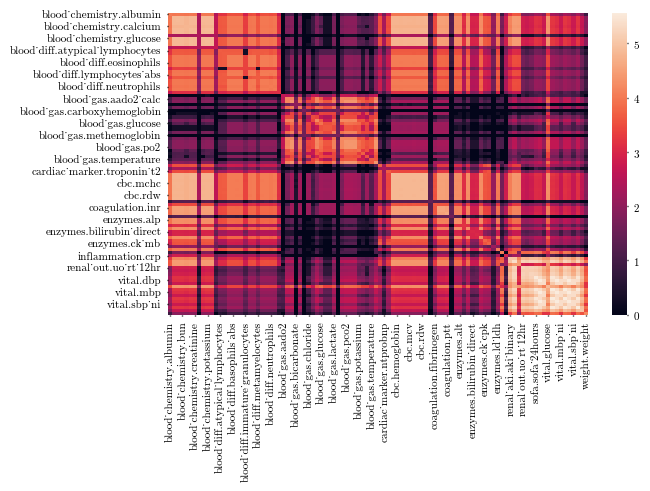

In [16]:

sns.heatmap(np.log10(cooc + 1))


In [17]:
np.mean(obs_mask)

0.08695259245595174

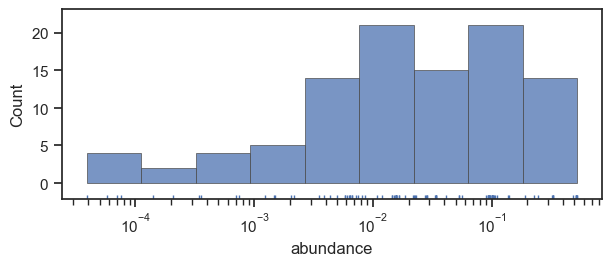

In [18]:
import matplotlib as mpl


p_mask = pd.DataFrame({'abundance': obs_mask.mean(axis=0)})


# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
# sns.rugplot(data=p_mask, x="abundance")
sns.set_theme(style="ticks")
# sns.kdeplot(data=p_mask, x="abundance", log_scale=True)
g = sns.rugplot(data=p_mask, x="abundance")
g.set_xscale('log')

sns.histplot(
    p_mask,
    x="abundance", 
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
g.get_figure().set_size_inches(fig_width_in, fig_height_in * 1.5)
g.get_figure().savefig(f"{RESULTS_DIR}/features_abundance.pdf")


# Model Configuration

In [19]:

def models(e):
    pmodels = {k: ProbStackedICNNImputer(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',  
                                         positivity='abs', hidden_size_multiplier=2, depth=4, key=jrandom.PRNGKey(0))
               for k in PROP_MODELS}
    dmodels =  {k: ICNNObsDecoder(observables_size=obs_mask.shape[1], state_size = 0, optax_optimiser_name='polyak_sgd',
                                  positivity='abs', hidden_size_multiplier=3, depth=5, key=jrandom.PRNGKey(0)) 
                for k in DET_MODELS}
    return (pmodels | dmodels)[e]
    
def trainers(e):
    return {
        'ICNN_LN': ProbICNNImputerTrainer(loss='log_normal'),
        'ICNN_NLN': ProbICNNImputerTrainer(loss='log_normal', loss_feature_normalisation=True),
        'ICNN_KL': ProbICNNImputerTrainer(loss='kl_divergence'),
        'ICNN_NKL': ProbICNNImputerTrainer(loss='kl_divergence', loss_feature_normalisation=True),
        'ICNN_MSE': StandardICNNImputerTrainer(),
        'ICNN_NMSE': StandardICNNImputerTrainer(loss_feature_normalisation=True)
    }[e]

# model = models(EXP)
# trainer = trainers(EXP)

# Training

## ICNN Training

In [20]:
# lr=1e-3
# steps=10000
# train_batch_size=256
# test_batch_size=1024
# # train_batch_size=1
# # test_batch_size=1
# eval_frequency = 10
# model_snapshot_frequency = 100

# optim = optax.novograd(lr)
# opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
# data_train = (obs_val_train, obs_mask_train, art_mask_train)
# data_test = (obs_val_test, obs_mask_test, art_mask_test)

In [21]:
# train_batches = trainer.dataloader(data_train, train_batch_size, key=jrandom.PRNGKey(0))
# test_batches = iter(trainer.dataloader(data_test, train_batch_size, key=jrandom.PRNGKey(0)))
# train_history = defaultdict(list)
# test_history = defaultdict(list)
# model_snapshots = {}

In [22]:
# progress = tqdm(range(steps))

# for step, batch_train in zip(progress, train_batches):
#     start = time.time()
#     (train_loss, train_aux), model, opt_state = trainer.make_step(model, optim, opt_state, *batch_train)
#     r2_vec =  trainer.model_r_squared(model, *batch_train)
#     r2_vec_rank = trainer.model_r_squared_ranked_prob(model, *batch_train, k=5)
#     r2_vec = np.array(r2_vec)
#     train_nsteps = int(sum(train_aux.n_steps) / len(train_aux.n_steps))
#     train_history['R2'].append(r2_vec)
#     train_history['R2_rank5'].append(r2_vec_rank)
#     train_history['loss'].append(train_loss)
#     train_history['n_opt_steps'].append(train_nsteps)
    
#     end = time.time()
#     if (step % eval_frequency) == 0 or step == steps - 1:
#         batch_test = next(test_batches)
#         test_loss, _ = trainer.loss(model, *batch_test)
#         r2_vec_test = trainer.model_r_squared(model, *batch_test)
#         r2_vec_rank_test = trainer.model_r_squared_ranked_prob(model, *batch_test, k=10)
#         r2_vec_test = np.array(r2_vec_test)
#         test_history['loss'].append(test_loss)
#         test_history['R2'].append(r2_vec_test)
#         test_history['R2_rank10'].append(r2_vec_rank_test)

#     if (step % model_snapshot_frequency) == 0 or step == steps - 1:
#         model_snapshots[step] = model
#         append_params_to_zip(model, f'step{step:04d}.eqx', f'{EXP_DIR[EXP]}/params.zip')

#     progress.set_description(f"Trn-L: {train_loss:.3f}, Trn-R2: ({np.nanmax(r2_vec_rank):.2f}, {np.nanmin(r2_vec_rank):.2f}, {np.nanmean(r2_vec_rank):.2f}, {np.nanmedian(r2_vec_rank):.2f}),  Trn-N-steps: {train_nsteps}, " 
#                              f"Tst-L:  {test_loss:.3f}, Tst-R2:  ({np.nanmax(r2_vec_rank_test):.2f}, {np.nanmin(r2_vec_rank_test):.2f}, {np.nanmean(r2_vec_rank_test):.2f}, {np.nanmedian(r2_vec_rank_test):.2f}), "
#                              f"Computation time: {end - start:.2f}, ")
                            

In [23]:
# zip_members(f'{EXP_DIR}/params.zip')

### Dump Training Statistics

In [24]:
# FIRST TIME - BEGIN 

# train_stats = pd.DataFrame(train_history)
# test_stats = pd.DataFrame(test_history)

# train_stats['split'] = 'Train'
# train_stats['iteration'] = train_stats.index + 1
# test_stats['split'] = 'Test'
# test_stats['iteration'] = (test_stats.index * eval_frequency) + 1
# training_stats = pd.concat([train_stats, test_stats])
# training_stats_melted = pd.melt(training_stats, value_vars=['loss'], id_vars=['split', 'iteration'], value_name='Loss')
# training_stats_melted = training_stats_melted.astype({'Loss': float})

# training_stats.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv')  
# training_stats_melted.to_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv')  

# FIRST TIME - END 


# LATER TIMES
# training_stats = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats.csv', index_col=[0])  
# training_stats_melted = pd.read_csv(f'{RESULTS_DIR}/{EXP}_training_stats_melted.csv', index_col=[0])  



# g2 = sns.lineplot(data=training_stats_melted, x="iteration", y="Loss", hue="split")
# g2.get_figure().set_size_inches(fig_width_in, fig_height_in)
# g2.get_figure().savefig(f"{RESULTS_DIR}/{EXP}_training_stats.pdf")

## Sklearn Training

In [25]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

# sklearn_trained_imputers = {k: v().fit(np.where(obs_mask_train, obs_val_train, np.nan)) for k, v in sklearn_imputers.items()} 

# Metrics / Results

In [26]:
prediction_mask = (1 - art_mask_test) * obs_mask_test
feature2index =  dict(zip(obs_val.columns, range(len(obs_val.columns))))
n_train = ((1 - art_mask_train) * obs_mask_train).sum(axis=0)
n_test = ((1 - art_mask_test) * obs_mask_test).sum(axis=0)
n_train_measured = obs_mask_train.sum(axis=0)
missingness = 1 - obs_mask.mean(axis=0)
validation_missingness = 1 - pd.DataFrame(art_mask_test, columns=obs_mask.columns).mean(axis=0)

In [27]:
n_test_censored = pd.Series(prediction_mask.sum(axis=0), index=obs_val.columns)
p_test_censored = n_test_censored / len(prediction_mask)
vars_n300 = n_test_censored[n_test_censored >= 300].index
vars_n300_r = n_test_censored[n_test_censored < 300].index
vars_n300, len(vars_n300)

(Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
        'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
        'blood_chemistry.calcium', 'blood_chemistry.chloride',
        'blood_chemistry.creatinine', 'blood_chemistry.glucose',
        'blood_chemistry.potassium', 'blood_chemistry.sodium',
        'blood_diff.basophils', 'blood_diff.basophils_abs',
        'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
        'blood_diff.lymphocytes', 'blood_diff.lymphocytes_abs',
        'blood_diff.monocytes', 'blood_diff.monocytes_abs',
        'blood_diff.neutrophils', 'blood_diff.neutrophils_abs',
        'blood_gas.aado2_calc', 'blood_gas.baseexcess', 'blood_gas.calcium',
        'blood_gas.fio2_chartevents', 'blood_gas.glucose', 'blood_gas.lactate',
        'blood_gas.pao2fio2ratio', 'blood_gas.pco2', 'blood_gas.ph',
        'blood_gas.po2', 'blood_gas.potassium', 'blood_gas.totalco2',
        'cardiac_marker.ck_mb', 'cardiac_marker.troponin_t2', 'cbc.hematocri

In [28]:
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  
                'blood_chemistry.bicarbonate': 'bc.Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen', 
                'blood_chemistry.calcium': 'bc.Calcium',  'blood_chemistry.chloride': 'bc.Chloride',  
                'blood_chemistry.creatinine': 'bc.Creatinine',  'blood_chemistry.globulin': 'Globulin',  
                'blood_chemistry.glucose': 'bc.Glucose',  'blood_chemistry.potassium': 'bc.Potassium',  
                'blood_chemistry.sodium': 'bc.Sodium',  'blood_chemistry.total_protein': 'Protein Total', 
                'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  
                'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils', 
                'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils', 
                'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',
                'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes', 
                'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes', 
                'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil', 
                'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',
                'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'bg.Bicarbonate',  'blood_gas.calcium': 'bg.Calcium',  
                'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'bg.Chloride',  'blood_gas.fio2': 'FiO2',  
                'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'bg.Glucose',  
                'blood_gas.hematocrit': 'bg.Hematocrit',  'blood_gas.hemoglobin': 'bg.Hemoglobin',  'blood_gas.lactate': 'Lactate', 
                'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',
                'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'bg.Potassium',  'blood_gas.so2': 'sO2', 
                'blood_gas.sodium': 'bg.Sodium',  'blood_gas.temperature': 'bg.Temperature',  'blood_gas.totalco2': 'CO2 total', 
                'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP', 
                'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'cbc.Hematocrit',  'cbc.hemoglobin': 'cbc.Hemoglobin', 
                'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC', 
                'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen', 
                'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',
                'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST', 
                'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',
                'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB', 
                'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',
                'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI', 
                'renal_creat.creat': 'renal.Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',
                'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP', 
                'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'vital.Glucose',  'vital.heart_rate': 'Heart Rate',  
                'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate', 
                'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  
                'vital.temperature': 'vital.Temperature',  'weight.weight': 'Weight'}

## Metrics Evolution with ICNN Training

In [29]:
# FIRST TIME - BEGIN 

# dataframes = []
# for step, model_snap in tqdm(model_snapshots.items()):
#     with jax.default_device(jax.devices("cpu")[0]):
#         obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#         (X_test_imp, X_test_std), _ = eqx.filter_vmap(model_snap.prob_partial_input_optimise)(obs_test, art_mask_test)
    
#     sigma_threshold = [4.0, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
#     r2_vec_thresholded = [eqx.filter_vmap(ProbICNNImputerTrainer.r_squared_thresholded_prob)(obs_val_test.T, X_test_imp.T, prediction_mask.T, X_test_std.T,  t)
#                           for t in sigma_threshold]
    
#     r2_test_results = pd.DataFrame(np.vstack(r2_vec_thresholded), columns=obs_val.columns)
#     r2_test_results['sigma_threshold'] = sigma_threshold
#     r2_test_results['step'] = step
#     dataframes.append(r2_test_results)

# r2_iters_test_results = pd.concat(dataframes)
# r2_iters_test_results = pd.melt(r2_iters_test_results, value_vars=list(obs_val.columns), id_vars=['sigma_threshold', 'step'], value_name='R2')

# r2_iters_test_results.to_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv')
# FIRST TIME - END 
# r2_iters_test_results = pd.read_csv(f'{RESULTS_DIR}/{EXP}_r2_iters_test_results.csv', index_col=[0])

In [30]:
# r2_iters_test_results

## Metrics of the Last ICNN Snapshot

### Inference with Last ICNN Snapshot (one-time)

In [31]:
# FIRST TIME - BEGIN 
# model = model.load_params_from_archive(f'{EXP_DIR[EXP]}/params.zip', 'step9999.eqx')
# with jax.default_device(jax.devices("cpu")[0]):
#     obs_test = jnp.where(art_mask_test, obs_val_test, 0.)
#     (X_test_imp, X_test_std), _ = eqx.filter_vmap(model.prob_partial_input_optimise)(obs_test, art_mask_test)

# X_test_imp_df = pd.DataFrame(X_test_imp, columns=obs_val.columns)
# X_test_std_df = pd.DataFrame(X_test_std, columns=obs_val.columns)

# X_test_imp_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_imp.csv')
# X_test_std_df.to_csv(f'{RESULTS_DIR}/{EXP}_pred_X_test_std.csv')
# FIRST TIME - END 

### Load ICNN Inference from Disk (one-time)

In [32]:
vars_n300

Index(['blood_chemistry.albumin', 'blood_chemistry.aniongap',
       'blood_chemistry.bicarbonate', 'blood_chemistry.bun',
       'blood_chemistry.calcium', 'blood_chemistry.chloride',
       'blood_chemistry.creatinine', 'blood_chemistry.glucose',
       'blood_chemistry.potassium', 'blood_chemistry.sodium',
       'blood_diff.basophils', 'blood_diff.basophils_abs',
       'blood_diff.eosinophils', 'blood_diff.eosinophils_abs',
       'blood_diff.lymphocytes', 'blood_diff.lymphocytes_abs',
       'blood_diff.monocytes', 'blood_diff.monocytes_abs',
       'blood_diff.neutrophils', 'blood_diff.neutrophils_abs',
       'blood_gas.aado2_calc', 'blood_gas.baseexcess', 'blood_gas.calcium',
       'blood_gas.fio2_chartevents', 'blood_gas.glucose', 'blood_gas.lactate',
       'blood_gas.pao2fio2ratio', 'blood_gas.pco2', 'blood_gas.ph',
       'blood_gas.po2', 'blood_gas.potassium', 'blood_gas.totalco2',
       'cardiac_marker.ck_mb', 'cardiac_marker.troponin_t2', 'cbc.hematocrit',
       'cbc

In [33]:
all_models_X_test_imp_df = {}
prob_models_X_test_std_df = {}
prob_models_X_var_stats_df = []
all_models_X_test_se = []
all_models_features_stats_df = []
all_models_stats_df = []
PERCENTILES = (95, 90, 80, 70, 60, 50, 25, 10)

for model_name in list(EXP_DIR.keys()) + list(sklearn_imputers.keys()):
    x_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_imp.csv'
    s_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_std.csv'
    if os.path.isfile(x_file):
        X_test_imp_ = pd.read_csv(x_file, index_col=[0])
        all_models_X_test_imp_df[model_name] = X_test_imp_

        # Squared-Errors (per instance)
        X_test_se_ = (X_test_imp_ - np.array(obs_val_test))**2
        X_test_se_ = X_test_se_.where(prediction_mask.astype(bool), other=np.nan)
        X_test_se_ = pd.melt(X_test_se_, value_vars=list(obs_val.columns), value_name='SE')
        X_test_se_ = X_test_se_[X_test_se_.SE.notnull()]
        X_test_se_['Imputer'] = model_name
        all_models_X_test_se.append(X_test_se_)


    if os.path.isfile(s_file):
        X_test_std_ = pd.read_csv(s_file, index_col=[0])
        prob_models_X_test_std_df[model_name] = X_test_std_
        
        X_test_var_ = np.where(prediction_mask.astype(bool), X_test_std_ ** 2, np.nan)
        SE_ = (all_models_X_test_imp_df[model_name] - np.array(obs_val_test)) ** 2
        SE_ = np.where(prediction_mask.astype(bool), SE_, np.nan)
        se_data_ = defaultdict(list)
        for i in range(SE_.shape[1]):
            se_data_['SE'].extend(np.array(SE_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_[r'$\hat{\sigma}^2$'].extend(np.array(X_test_var_[:, i][prediction_mask[:, i].astype(bool)]).tolist())
            se_data_['Feature'].extend([obs_val.columns[i]] * int(prediction_mask[:, i].sum()))
        se_df_ = pd.DataFrame(se_data_)
        se_df_['Imputer'] = model_name
        
        prob_models_X_var_stats_df.append(se_df_)

    if model_name not in all_models_X_test_imp_df:
        continue

    # R2/MSE (per feature)
    X_test_imp_ = jnp.array(all_models_X_test_imp_df[model_name])
    features_r2_ = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask.T)
    se_ = (np.array(all_models_X_test_imp_df[model_name]) - np.array(obs_val_test)) ** 2
    mse_ = np.nanmean(se_, axis=0, where=prediction_mask.astype(bool))
    features_stats_df_ = pd.DataFrame({r'$R^2$': np.array(features_r2_), 
                                       'MSE': mse_,
                                       'Feature': all_models_X_test_imp_df[model_name].columns,
                                       'Imputer': [model_name] * len(mse_)})

    # r_spearman(SE, sigma2) (per feature)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan)
        features_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_i[mi], sigma2_i[mi]).statistic
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T)]
        features_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_i[mi], sigma2_i[mi]).statistic if mi.sum() > 2 else float('nan')
                                                 for se_i, sigma2_i, mi in zip(se_.T, X_test_var_.T, prediction_mask.astype(bool).T) ]
        
        # After Transpose, shape: (N_percentiles, n_features)
        features_percentiles = np.vstack([np.percentile(sigma2_i[mi], PERCENTILES)  for (sigma2_i, mi) in zip(X_test_var_.T, prediction_mask.astype(bool).T)]).T

        for percent, percentile in zip(PERCENTILES, features_percentiles):
            prediction_mask_p = np.vstack([mi * (sigma2_i <= p_i) for 
                                           (p_i, sigma2_i, mi) in zip(percentile, X_test_var_.T, prediction_mask.astype(bool).T)]).T
            features_stats_df_[rf'$R^2@P{percent}$'] = np.array(eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(obs_val_test.T, X_test_imp_.T, prediction_mask_p.T)).squeeze()
            features_stats_df_[f'MSE@P{percent}'] = np.nanmean(se_, axis=0, where=prediction_mask_p).squeeze()

        
        
        

    all_models_features_stats_df.append(features_stats_df_)

    # R2/MSE (per model)
    features_stats_300_df = features_stats_df_[features_stats_df_.Feature.isin(vars_n300)]
    weighted_avg_R2 = np.average(features_stats_300_df[r'$R^2$'], 
                                 weights=features_stats_300_df['Feature'].map(n_test_censored))
    
    model_stats_df_ = pd.DataFrame({'Imputer': [model_name],
                                    'MSE': [np.nanmean(se_, where=prediction_mask.astype(bool))],
                                    r'$R^2$': [ProbICNNImputerTrainer.r_squared(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MICRO-AVG($R^2$)': [ProbICNNImputerTrainer.r_squared_micro_average(obs_val_test, X_test_imp_, prediction_mask).item()],
                                    r'MACRO-AVG($R^2$)*': [features_stats_300_df[r'$R^2$'].mean()]})

    # corr(SE, sigma2) (per model)
    if model_name in prob_models_X_test_std_df:
        X_test_var_ = np.where(prediction_mask.astype(bool), prob_models_X_test_std_df[model_name] ** 2, np.nan).flatten()
        m_ = prediction_mask.astype(bool).flatten()
        model_stats_df_[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] = [pearsonr(se_.flatten()[m_], X_test_var_[m_]).statistic]
        model_stats_df_[r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$'] = [spearmanr(se_.flatten()[m_], X_test_var_[m_]).statistic]
    all_models_stats_df.append(model_stats_df_)
    
all_models_X_test_se = pd.concat(all_models_X_test_se)
prob_models_X_var_stats_df = pd.concat(prob_models_X_var_stats_df)
all_models_features_stats_df = pd.concat(all_models_features_stats_df)
all_models_stats_df = pd.concat(all_models_stats_df)

In [34]:
all_models_features_stats_df

,$R^2$,MSE,Feature,Imputer,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,$R^2@P70$,MSE@P70,$R^2@P60$,MSE@P60,$R^2@P50$,MSE@P50,$R^2@P25$,MSE@P25,$R^2@P10$,MSE@P10
0,-18.791556,0.338596,blood_chemistry.albumin,ICNN_LN,-0.095714,-0.034393,-18.691674,0.338215,-18.553556,0.334983,...,-18.024524,0.336092,-18.707694,0.352295,-19.748382,0.357047,-21.102295,0.394709,-20.815064,0.393653
1,-0.633369,0.032923,blood_chemistry.aniongap,ICNN_LN,0.151935,0.157638,-0.585307,0.031776,-0.535327,0.030897,...,-0.398683,0.027410,-0.356028,0.026467,-0.333570,0.026126,-0.263334,0.024645,-0.282157,0.023480
2,-0.511465,0.020465,blood_chemistry.bicarbonate,ICNN_LN,0.113759,0.271554,-0.424245,0.018885,-0.390915,0.018302,...,-0.325593,0.017050,-0.276897,0.016368,-0.237823,0.015681,-0.215493,0.015647,-0.163615,0.014520
3,-0.219971,0.051564,blood_chemistry.bun,ICNN_LN,0.058487,0.073982,-0.209860,0.050390,-0.201838,0.049888,...,-0.171863,0.048979,-0.160660,0.047289,-0.161099,0.046119,-0.138065,0.045162,-0.128952,0.042524
4,-2.204620,0.012969,blood_chemistry.calcium,ICNN_LN,0.103926,0.192224,-1.986297,0.012110,-1.938129,0.011876,...,-1.652187,0.010797,-1.616448,0.010503,-1.553678,0.010375,-1.834415,0.011760,-1.797227,0.012877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.452593,0.007647,vital.sbp,iter_imputer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,0.820376,0.002518,vital.sbp_ni,iter_imputer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,-0.972564,0.001281,vital.spo2,iter_imputer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,-0.918125,0.000421,vital.temperature,iter_imputer,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
prob_models_X_var_stats_df['LN'] = prob_models_X_var_stats_df['SE'] / prob_models_X_var_stats_df[r'$\hat{\sigma}^2$'] + np.log(prob_models_X_var_stats_df[r'$\hat{\sigma}^2$'])

In [36]:
# all_models_features_stats_df
features_LN = prob_models_X_var_stats_df.groupby(['Imputer', 'Feature'])['LN'].mean()
all_models_features_stats_df = all_models_features_stats_df.set_index(['Imputer', 'Feature'])
all_models_features_stats_df.loc[features_LN.index, 'LN'] = features_LN
all_models_features_stats_df = all_models_features_stats_df.reset_index()
all_models_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,MSE@P70,$R^2@P60$,MSE@P60,$R^2@P50$,MSE@P50,$R^2@P25$,MSE@P25,$R^2@P10$,MSE@P10,LN
0,ICNN_LN,blood_chemistry.albumin,-18.791556,0.338596,-0.095714,-0.034393,-18.691674,0.338215,-18.553556,0.334983,...,0.336092,-18.707694,0.352295,-19.748382,0.357047,-21.102295,0.394709,-20.815064,0.393653,0.800282
1,ICNN_LN,blood_chemistry.aniongap,-0.633369,0.032923,0.151935,0.157638,-0.585307,0.031776,-0.535327,0.030897,...,0.027410,-0.356028,0.026467,-0.333570,0.026126,-0.263334,0.024645,-0.282157,0.023480,-2.403913
2,ICNN_LN,blood_chemistry.bicarbonate,-0.511465,0.020465,0.113759,0.271554,-0.424245,0.018885,-0.390915,0.018302,...,0.017050,-0.276897,0.016368,-0.237823,0.015681,-0.215493,0.015647,-0.163615,0.014520,-2.918142
3,ICNN_LN,blood_chemistry.bun,-0.219971,0.051564,0.058487,0.073982,-0.209860,0.050390,-0.201838,0.049888,...,0.048979,-0.160660,0.047289,-0.161099,0.046119,-0.138065,0.045162,-0.128952,0.042524,-1.932642
4,ICNN_LN,blood_chemistry.calcium,-2.204620,0.012969,0.103926,0.192224,-1.986297,0.012110,-1.938129,0.011876,...,0.010797,-1.616448,0.010503,-1.553678,0.010375,-1.834415,0.011760,-1.797227,0.012877,-3.281671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
models_LN = prob_models_X_var_stats_df.groupby(['Imputer'])['LN'].mean()
all_models_stats_df = all_models_stats_df.set_index('Imputer')
all_models_stats_df.loc[models_LN.index, 'LN'] = models_LN
all_models_stats_df = all_models_stats_df.reset_index()
all_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$",LN
0,ICNN_LN,0.110200,0.088884,-0.097980,-14.683217,0.486482,0.528621,-2.645586
1,ICNN_NLN,0.092614,0.234282,0.077238,-0.977603,0.359050,0.523306,-2.853713
2,ICNN_KL,0.085771,0.290860,0.145420,-8.980603,0.011902,0.182318,155.905403
3,ICNN_NKL,0.081217,0.328510,0.190792,-8.052747,0.027086,0.196668,15.434565
4,ICNN_MSE,0.103783,0.141939,-0.034043,-0.636587,NaN,NaN,NaN
5,ICNN_NMSE,0.094326,0.220125,0.060177,-0.046894,NaN,NaN,NaN
6,zero_imputer,0.188635,-0.559605,-0.879470,-4.101035,NaN,NaN,NaN
7,mean_imputer,0.100373,0.170128,-0.000074,-0.000799,NaN,NaN,NaN
8,knn_imputer,0.142751,-0.180250,-0.422312,0.143208,NaN,NaN,NaN
9,iter_imputer,0.086248,0.286912,0.140662,-0.229407,NaN,NaN,NaN


In [38]:
prob_models_X_var_stats_df.groupby(['Imputer'])['LN'].mean()

Imputer
ICNN_KL     155.905403
ICNN_LN      -2.645586
ICNN_NKL     15.434565
ICNN_NLN     -2.853713
Name: LN, dtype: float64

In [39]:
all_models_features_stats_df.Imputer.unique()

array(['ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL', 'ICNN_MSE',
       'ICNN_NMSE', 'zero_imputer', 'mean_imputer', 'knn_imputer',
       'iter_imputer'], dtype=object)

In [40]:
p_abundance = obs_mask.mean(axis=0)
for name, model_df in all_models_features_stats_df.groupby('Imputer'):
    df = model_df[model_df.Feature.isin(vars_n300)]
    stat = spearmanr(df[r'$R^2$'], df.Feature.map(p_abundance)).statistic
    loc = all_models_stats_df.Imputer == name
    all_models_stats_df.loc[loc, r'$r_\text{Spearman}(R^2, \text{abundance})$'] = stat
    

In [41]:
all_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$",LN,"$r_\text{Spearman}(R^2, \text{abundance})$"
0,ICNN_LN,0.110200,0.088884,-0.097980,-14.683217,0.486482,0.528621,-2.645586,0.622578
1,ICNN_NLN,0.092614,0.234282,0.077238,-0.977603,0.359050,0.523306,-2.853713,0.443354
2,ICNN_KL,0.085771,0.290860,0.145420,-8.980603,0.011902,0.182318,155.905403,0.380291
3,ICNN_NKL,0.081217,0.328510,0.190792,-8.052747,0.027086,0.196668,15.434565,0.253702
4,ICNN_MSE,0.103783,0.141939,-0.034043,-0.636587,NaN,NaN,NaN,0.157781
5,ICNN_NMSE,0.094326,0.220125,0.060177,-0.046894,NaN,NaN,NaN,-0.135166
6,zero_imputer,0.188635,-0.559605,-0.879470,-4.101035,NaN,NaN,NaN,-0.420739
7,mean_imputer,0.100373,0.170128,-0.000074,-0.000799,NaN,NaN,NaN,0.413396
8,knn_imputer,0.142751,-0.180250,-0.422312,0.143208,NaN,NaN,NaN,-0.142324
9,iter_imputer,0.086248,0.286912,0.140662,-0.229407,NaN,NaN,NaN,0.077502


In [42]:
all_models_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,MSE@P70,$R^2@P60$,MSE@P60,$R^2@P50$,MSE@P50,$R^2@P25$,MSE@P25,$R^2@P10$,MSE@P10,LN
0,ICNN_LN,blood_chemistry.albumin,-18.791556,0.338596,-0.095714,-0.034393,-18.691674,0.338215,-18.553556,0.334983,...,0.336092,-18.707694,0.352295,-19.748382,0.357047,-21.102295,0.394709,-20.815064,0.393653,0.800282
1,ICNN_LN,blood_chemistry.aniongap,-0.633369,0.032923,0.151935,0.157638,-0.585307,0.031776,-0.535327,0.030897,...,0.027410,-0.356028,0.026467,-0.333570,0.026126,-0.263334,0.024645,-0.282157,0.023480,-2.403913
2,ICNN_LN,blood_chemistry.bicarbonate,-0.511465,0.020465,0.113759,0.271554,-0.424245,0.018885,-0.390915,0.018302,...,0.017050,-0.276897,0.016368,-0.237823,0.015681,-0.215493,0.015647,-0.163615,0.014520,-2.918142
3,ICNN_LN,blood_chemistry.bun,-0.219971,0.051564,0.058487,0.073982,-0.209860,0.050390,-0.201838,0.049888,...,0.048979,-0.160660,0.047289,-0.161099,0.046119,-0.138065,0.045162,-0.128952,0.042524,-1.932642
4,ICNN_LN,blood_chemistry.calcium,-2.204620,0.012969,0.103926,0.192224,-1.986297,0.012110,-1.938129,0.011876,...,0.010797,-1.616448,0.010503,-1.553678,0.010375,-1.834415,0.011760,-1.797227,0.012877,-3.281671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
r_classes = [r'$r > 0.3$', r'$r \in [0.1, 0.3]$', r'$r \in [-0.1, 0.1]$', r'$r \leq -0.1$']
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in [-0.1, 0.1]$', r'$R^2 \in (-1, -0.1]$',  r'$R^2 \in (-9, -1]$', r'$R^2 < -9$']
def classify_r(r):
    if r > 0.3:
        return r_classes[0]
    elif r > 0.1:
        return r_classes[1]
    elif r >= -0.1:
        return r_classes[2]
    elif r < -0.1:
        return r_classes[3]
    else:
        return 'NA'

def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R >= -0.1:
        return R_classes[2]
    elif R >= -1:
        return R_classes[3] 
    elif R >= -9:
        return R_classes[4]
    elif R < -9:
        return R_classes[5]
    else:
        return 'NA'

all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'] = all_models_features_stats_df[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'].map(classify_r)
all_models_features_stats_df[r'$R^2$ bin'] = all_models_features_stats_df[r'$R^2$'].map(classify_R)


In [44]:
for p in PERCENTILES:
    all_models_features_stats_df[rf'$R^2@P{p}$ bin'] = all_models_features_stats_df[rf'$R^2@P{p}$'].map(classify_R)


In [45]:
all_models_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,"$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin
0,ICNN_LN,blood_chemistry.albumin,-18.791556,0.338596,-0.095714,-0.034393,-18.691674,0.338215,-18.553556,0.334983,...,"$r \in [-0.1, 0.1]$",$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$
1,ICNN_LN,blood_chemistry.aniongap,-0.633369,0.032923,0.151935,0.157638,-0.585307,0.031776,-0.535327,0.030897,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
2,ICNN_LN,blood_chemistry.bicarbonate,-0.511465,0.020465,0.113759,0.271554,-0.424245,0.018885,-0.390915,0.018302,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
3,ICNN_LN,blood_chemistry.bun,-0.219971,0.051564,0.058487,0.073982,-0.209860,0.050390,-0.201838,0.049888,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
4,ICNN_LN,blood_chemistry.calcium,-2.204620,0.012969,0.103926,0.192224,-1.986297,0.012110,-1.938129,0.011876,...,"$r \in [0.1, 0.3]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
996,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
997,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA
998,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA


In [46]:
prob_models_features_stats_df = all_models_features_stats_df[all_models_features_stats_df[r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'].notnull()]
prob_models_features_stats_df = prob_models_features_stats_df[prob_models_features_stats_df.Feature.isin(vars_n300)]

prob_models_features_stats_df['Imputer'] = prob_models_features_stats_df['Imputer'].map(ICNN_RENAMES)

r_bins = prob_models_features_stats_df.groupby(['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin'])['Feature'].count().reset_index()
r_bins.columns = ['Imputer', r'$r(SE, \hat{\sigma}^2)$ bin', 'Count']
r_bins = r_bins.pivot_table(index="Imputer", values='Count', columns=r'$r(SE, \hat{\sigma}^2)$ bin')

# r_bins = r_bins[r_classes]
r_bins

"$r(SE, \hat{\sigma}^2)$ bin",$r > 0.3$,"$r \in [-0.1, 0.1]$","$r \in [0.1, 0.3]$",$r \leq -0.1$
Imputer,,,,
P-ICNN (KL),6.0,31.0,35.0,1.0
P-ICNN (LN),9.0,18.0,46.0,NaN
P-ICNN (NKL),3.0,37.0,33.0,NaN
P-ICNN (NLN),13.0,31.0,29.0,NaN


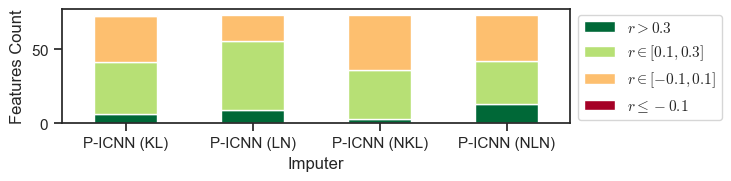

In [47]:
ax = r_bins.plot(y=r_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 1.2, fig_height_in)
ax.get_figure().savefig(f"{RESULTS_DIR}/prob_icnn_r_bins.pdf")

In [48]:
table_ablation0 = all_models_stats_df.copy()

table_ablation0['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation0.Imputer.unique() if m == m and  m.startswith('P-ICNN')]

table_ablation0 = table_ablation0.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)',  r'MACRO-AVG($R^2$)*', 'LN', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$'] ].transpose()
table_ablation0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation0.columns))
table_ablation0.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation0.columns))
table_ablation0.columns.name = 'Imputer'
table_ablation0 = table_ablation0.sort_values('MSE', ascending=False, axis=1)
table_ablation0

Imputer,\texttt{P-ICNN (LN)},\texttt{P-ICNN (NLN)},\texttt{P-ICNN (KL)},\texttt{P-ICNN (NKL)}
MSE,0.110200,0.092614,0.085771,0.081217
MICRO-AVG($R^2$),-0.097980,0.077238,0.145420,0.190792
MACRO-AVG($R^2$)*,-14.683217,-0.977603,-8.980603,-8.052747
LN,-2.645586,-2.853713,155.905403,15.434565
"$r_\text{Pearson}(SE, \hat{\sigma}^2)$",0.486482,0.359050,0.011902,0.027086


In [49]:
table_stl_ablation0 = (table_ablation0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.08, high=0.110,  vmin=0.08, vmax=0.110, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation0

Imputer,\texttt{P-ICNN (LN)},\texttt{P-ICNN (NLN)},\texttt{P-ICNN (KL)},\texttt{P-ICNN (NKL)}
MSE,0.110,0.093,0.086,0.081
MICRO-AVG($R^2$),-0.098,0.077,0.145,0.191
MACRO-AVG($R^2$)*,-14.683,-0.978,-8.981,-8.053
LN,-2.646,-2.854,155.905,15.435
"$r_\text{Pearson}(SE, \hat{\sigma}^2)$",0.486,0.359,0.012,0.027


In [50]:
table_ltx_ablation0 = (table_stl_ablation0.to_latex(caption=r"Ablation study on the effect of the probabilistic loss function choice on the performance of "
                                                    r"\texttt{P-ICNN} models. "
                                                    r"First row: \gls*{mse} loss across all features on the test split. "
                                                    r"Second and third rows list the micro and macro average of $R^2$ (higher is better), respectively. "
                                                    r"For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values. "
                                                    r"Last row: correlation between squared error and predicted variance (the higher the better).",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation0)

\begin{table}
\centering
\caption{Ablation study on the effect of the probabilistic loss function choice on the performance of \texttt{P-ICNN} models. First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ (higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, of which some have $-\infty$ values. Last row: correlation between squared error and predicted variance (the higher the better).}
\begin{tabular}{lrrrr}
\hline
Imputer & \texttt{P-ICNN (LN)} & \texttt{P-ICNN (NLN)} & \texttt{P-ICNN (KL)} & \texttt{P-ICNN (NKL)} \\
\hline
MSE & {\cellcolor[HTML]{D02927}} \color[HTML]{F1F1F1} 0.110 & {\cellcolor[HTML]{E0F295}} \color[HTML]{000000} 0.093 & {\cellcolor[HTML]{78C565}} \color[HTML]{000000} 0.086 & {\cellcolor[HTML]{199750}} \color[HTML]{F1F1F1} 0.081 \\
MICRO-AVG($R^2$) & -0.098 & 0.077 & 0.145 & 0.191 \\
MACRO-AVG($R^2$)* & -14.683 & -

In [51]:
table_ablation1 = all_models_stats_df.copy()

table_ablation1['Imputer'] = all_models_stats_df['Imputer'].map(ICNN_RENAMES)
ablation_models = [m for m in table_ablation1.Imputer.unique() if m == m and  m.startswith('S-ICNN')]

table_ablation1 = table_ablation1.set_index('Imputer').loc[ablation_models,  ['MSE', r'MICRO-AVG($R^2$)', r'MACRO-AVG($R^2$)*'] ].transpose()
table_ablation1.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table_ablation1.columns))
table_ablation1.columns = list(map(lambda c: c.replace("_", "\\_"), table_ablation1.columns))
table_ablation1.columns.name = 'Imputer'
table_ablation1 = table_ablation1.sort_values('MSE', ascending=False, axis=1)
table_ablation1

Imputer,\texttt{S-ICNN (MSE)},\texttt{S-ICNN (NMSE)}
MSE,0.103783,0.094326
MICRO-AVG($R^2$),-0.034043,0.060177
MACRO-AVG($R^2$)*,-0.636587,-0.046894


In [52]:
table_stl_ablation1 = (table_ablation1.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'$R^2$'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.08, high=0.110,  vmin=0.08, vmax=0.110, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table_stl_ablation1

Imputer,\texttt{S-ICNN (MSE)},\texttt{S-ICNN (NMSE)}
MSE,0.104,0.094
MICRO-AVG($R^2$),-0.034,0.060
MACRO-AVG($R^2$)*,-0.637,-0.047


In [53]:
table_ltx_ablation1 = (table_stl_ablation1.to_latex(caption=r"Ablation study on the effect of the loss function choice on the performance of \texttt{S-ICNN} models. "
                                                    r"First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ "
                                                    r"(higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, "
                                                    r"of which some have $-\infty$ values.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table_ltx_ablation1)

\begin{table}
\centering
\caption{Ablation study on the effect of the loss function choice on the performance of \texttt{S-ICNN} models. First row: \gls*{mse} loss across all features on the test split. Second and third rows list the micro and macro average of $R^2$ (higher is better), respectively. For the $\text{MACRO-AVG}(R^2)*$, features with less than $N<300$ in the test split are excluded, of which some have $-\infty$ values.}
\begin{tabular}{lrr}
\hline
Imputer & \texttt{S-ICNN (MSE)} & \texttt{S-ICNN (NMSE)} \\
\hline
MSE & {\cellcolor[HTML]{FA9857}} \color[HTML]{000000} 0.104 & {\cellcolor[HTML]{F2FAAE}} \color[HTML]{000000} 0.094 \\
MICRO-AVG($R^2$) & -0.034 & 0.060 \\
MACRO-AVG($R^2$)* & -0.637 & -0.047 \\
\hline
\end{tabular}
\end{table}



In [54]:
S_ICNN = ('ICNN_NMSE', )
P_ICNN = ('ICNN_NKL', 'ICNN_NLN')
# P_ICNN_RENAME = {'ICNN_NKL': 'ICNN (KL)', 
#                  'ICNN_NLN': 'ICNN (LN)'}

final_models_X_test_se = all_models_X_test_se[((all_models_X_test_se.Imputer.str.count('ICNN') == 0) | 
                                               (all_models_X_test_se.Imputer.isin(S_ICNN + P_ICNN)))]

final_models_features_stats_df = all_models_features_stats_df[((all_models_features_stats_df.Imputer.str.count('ICNN') == 0) |
                                                               (all_models_features_stats_df.Imputer.isin(S_ICNN + P_ICNN)))]
final_models_stats_df = all_models_stats_df[((all_models_stats_df.Imputer.str.count('ICNN') == 0) |
                                             (all_models_stats_df.Imputer.isin(S_ICNN + P_ICNN)))]

for df in (final_models_X_test_se, final_models_features_stats_df, final_models_stats_df):
    df['Imputer'] = df['Imputer'].replace(ICNN_RENAMES)   


/tmp/ipykernel_79657/1210049231.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Imputer'] = df['Imputer'].replace(ICNN_RENAMES)


In [55]:
final_models_stats_df.Imputer.unique()

array(['P-ICNN (NLN)', 'P-ICNN (NKL)', 'S-ICNN (NMSE)', 'zero_imputer',
       'mean_imputer', 'knn_imputer', 'iter_imputer'], dtype=object)

## Metrics of Sklearn Models

In [56]:
# FIRST TIME - BEGIN 
# sklearn_imputed_X = {k: v.transform(np.where(art_mask_test, obs_val_test, np.nan)) for k, v in sklearn_trained_imputers.items()} 
# for sklearn_name, imputed_X_ in sklearn_imputed_X.items():
#     X_test_imp_df = pd.DataFrame(imputed_X_, columns=obs_val.columns)    
#     X_test_imp_df.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv')
# FIRST TIME - END 

In [57]:
all_models_X_test_se.Imputer.unique()

array(['ICNN_LN', 'ICNN_NLN', 'ICNN_KL', 'ICNN_NKL', 'ICNN_MSE',
       'ICNN_NMSE', 'zero_imputer', 'mean_imputer', 'knn_imputer',
       'iter_imputer'], dtype=object)

In [58]:
final_models_X_test_se['group'] = final_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
final_models_X_test_se['Feature'] = final_models_X_test_se.variable.map(variable_map)

/tmp/ipykernel_79657/4136769991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_models_X_test_se['group'] = final_models_X_test_se.variable.str.split('.').map(lambda x: x[0])
/tmp/ipykernel_79657/4136769991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_models_X_test_se['Feature'] = final_models_X_test_se.variable.map(variable_map)


In [59]:
groups = final_models_X_test_se['group'].unique().tolist()
groups

['blood_chemistry',
 'blood_diff',
 'blood_gas',
 'cardiac_marker',
 'cbc',
 'coagulation',
 'enzymes',
 'icp',
 'inflammation',
 'renal_aki',
 'renal_creat',
 'renal_out',
 'sofa',
 'vital',
 'weight']

/home/asem/GP/env/icenode-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


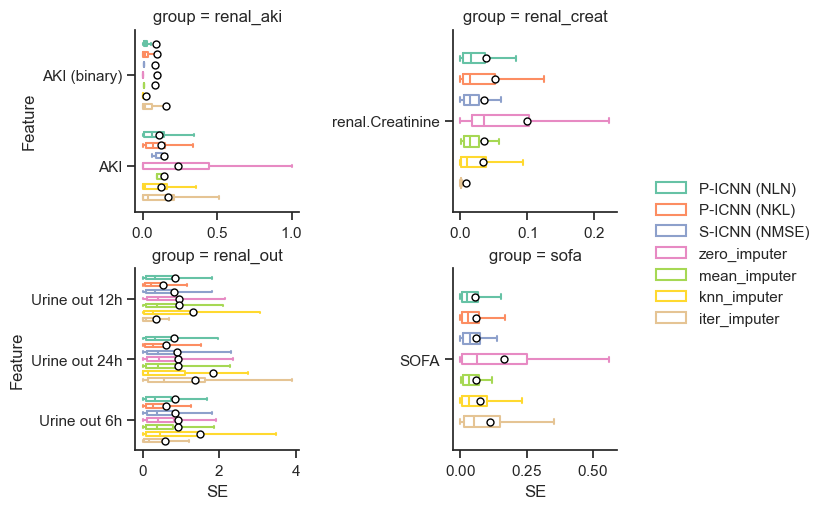

In [60]:
# enzymes (except Amylase, Bilirubin indirect, CK-CPK)
# renal_creat
# renal_aki
# renal_out
# sofa

X_test_se_df_selection = final_models_X_test_se[final_models_X_test_se.group.isin(['renal_out', 'renal_creat', 'renal_aki', 'sofa'])]

grid = sns.FacetGrid(data=X_test_se_df_selection, col="group", sharex=False, sharey=False, col_wrap=2,  )

grid.map_dataframe(sns.boxplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
                   showmeans=True, meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'5'},
                    # line_kws=dict(linewidth=1.5, color="#cde"),
                    showfliers=False,
                    fill=False,
                     gap=0.5)

# grid.map_dataframe(sns.boxenplot, x="SE", y="Feature", hue="Imputer", dodge=True,  palette="Set2",#hue="Imputer",
#                     # line_kws=dict(linewidth=1.5, color="#cde"),
#                     showfliers=False,
#                     fill=False,
#                      gap=0.5)

grid.add_legend()
grid.figure.set_size_inches(fig_width_in * 1.5, fig_height_in * 3)
grid.savefig(f"{RESULTS_DIR}/X_test_se_df_selection.pdf")

In [61]:

all_models_features_stats_df['abundance'] = all_models_features_stats_df.Feature.map(p_abundance)

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[:2]) &
                             all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:2]))]


,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin,abundance
141,ICNN_NLN,blood_gas.pao2fio2ratio,0.182905,0.031050,0.086152,0.161293,0.215420,0.029329,0.221486,0.028953,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$",0.022511
167,ICNN_NLN,coagulation.thrombin,0.576546,0.017278,0.500000,0.158936,0.642057,0.016792,0.642057,0.016792,...,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,NA,NA,0.000058
182,ICNN_NLN,renal_aki.aki_stage_smoothed,0.249949,0.106696,0.293069,0.188600,0.267008,0.103830,0.279245,0.102455,...,"$R^2 \in (0.1, 0.25]$",$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,$R^2 > 0.25$,"$R^2 \in [-0.1, 0.1]$",0.323320
185,ICNN_NLN,renal_out.uo_rt_24hr,0.120927,0.820029,0.021880,0.124398,0.116140,0.762742,0.113189,0.724004,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$",0.192998
189,ICNN_NLN,vital.dbp_ni,0.103632,0.017161,-0.001285,0.102090,0.130607,0.016676,0.129110,0.016798,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$",0.328656
192,ICNN_NLN,vital.mbp,0.134596,0.012275,0.018783,0.112599,0.147199,0.012091,0.149414,0.012058,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$",0.516103
193,ICNN_NLN,vital.mbp_ni,0.161115,0.012801,-0.023529,0.353951,0.216603,0.012018,0.220777,0.012006,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$",0.329229


In [62]:

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[:2]) &
                             all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[2:]))]


,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin,abundance
132,ICNN_NLN,blood_gas.carboxyhemoglobin,0.101116,0.02809,-0.400000,-0.578978,0.234004,0.031917,0.234004,0.031917,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",NA,NA,0.000071
184,ICNN_NLN,renal_out.uo_rt_12hr,0.113955,0.83722,0.013572,0.099526,0.115233,0.803272,0.113283,0.778357,...,"$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$",0.229034


In [63]:

all_models_features_stats_df[((all_models_features_stats_df.Imputer == 'ICNN_NLN') & 
                              # all_models_features_stats_df[r'$R^2$ bin'].isin(R_classes[1:]) &
                             all_models_features_stats_df[r'$r(SE, \hat{\sigma}^2)$ bin'].isin(r_classes[:1]) &
                              (all_models_features_stats_df['LN'] < -2))
]


,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin,abundance
110,ICNN_NLN,blood_chemistry.sodium,-1.941753,0.002294,0.173698,0.335113,-1.545258,0.001972,-1.424081,0.001878,...,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$",0.103741
131,ICNN_NLN,blood_gas.calcium,-1.628837,0.005189,0.023724,0.868007,-1.025371,0.003875,-0.987763,0.003902,...,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",0.016567
136,ICNN_NLN,blood_gas.glucose,-0.280113,0.027748,0.091412,0.331892,-0.113544,0.024654,-0.100065,0.024143,...,"$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$",0.011852
142,ICNN_NLN,blood_gas.pco2,-0.085574,0.018721,0.014528,0.444628,-0.013534,0.017558,0.005973,0.017565,...,"$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$",0.034377
143,ICNN_NLN,blood_gas.ph,-10.074573,0.001135,0.021290,0.519898,-2.467056,0.000354,-2.254003,0.000336,...,$R^2 < -9$,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",0.034355
145,ICNN_NLN,blood_gas.potassium,-0.298432,0.012059,-0.059661,0.557555,-0.103090,0.010523,-0.073921,0.010582,...,"$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$",0.010862
147,ICNN_NLN,blood_gas.sodium,-8.577980,0.005984,0.067703,0.361511,-7.668025,0.005253,-7.290771,0.005061,...,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$",0.005035
148,ICNN_NLN,blood_gas.temperature,-14.977194,0.006159,0.121654,0.810706,-13.286572,0.005427,-13.359507,0.005330,...,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,$R^2 < -9$,"$R^2 \in (-9, -1]$",0.006342
150,ICNN_NLN,cardiac_marker.ck_mb,-1.220916,0.028226,0.274242,0.303879,-1.051055,0.026300,-0.902248,0.025224,...,"$R^2 \in (-9, -1]$","$R^2 \in (-9, -1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$",0.007445
156,ICNN_NLN,cbc.mchc,-0.734992,0.003315,0.157349,0.312867,-0.584503,0.002985,-0.482656,0.002776,...,"$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$",0.095521


In [64]:
# TODO: For each feature, exclude the points on the upper part of uncertainty, then recompute the metrics again.

In [65]:
final_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*,"$r_\text{Pearson}(SE, \hat{\sigma}^2)$","$r_\text{Spearman}(SE, \hat{\sigma}^2)$",LN,"$r_\text{Spearman}(R^2, \text{abundance})$"
1,P-ICNN (NLN),0.092614,0.234282,0.077238,-0.977603,0.359050,0.523306,-2.853713,0.443354
3,P-ICNN (NKL),0.081217,0.328510,0.190792,-8.052747,0.027086,0.196668,15.434565,0.253702
5,S-ICNN (NMSE),0.094326,0.220125,0.060177,-0.046894,NaN,NaN,NaN,-0.135166
6,zero_imputer,0.188635,-0.559605,-0.879470,-4.101035,NaN,NaN,NaN,-0.420739
7,mean_imputer,0.100373,0.170128,-0.000074,-0.000799,NaN,NaN,NaN,0.413396
8,knn_imputer,0.142751,-0.180250,-0.422312,0.143208,NaN,NaN,NaN,-0.142324
9,iter_imputer,0.086248,0.286912,0.140662,-0.229407,NaN,NaN,NaN,0.077502


In [66]:
table0 = final_models_stats_df.drop(axis=1, labels=[r'MACRO-AVG($R^2$)*', r'$R^2$', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$',
       r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$']) .set_index('Imputer').transpose()
table0.columns =  list(map(lambda c: f'\\texttt{{{c}}}', table0.columns))
table0.columns = list(map(lambda c: c.replace("_", "\\_"), table0.columns))
table0.columns.name = 'Imputer'
table0 = table0.sort_values('MSE', axis=1, ascending=False)
table0

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{mean\_imputer},\texttt{S-ICNN (NMSE)},\texttt{P-ICNN (NLN)},\texttt{iter\_imputer},\texttt{P-ICNN (NKL)}
MSE,0.188635,0.142751,0.100373,0.094326,0.092614,0.086248,0.081217
MICRO-AVG($R^2$),-0.879470,-0.422312,-0.000074,0.060177,0.077238,0.140662,0.190792
LN,NaN,NaN,NaN,NaN,-2.853713,NaN,15.434565
"$r_\text{Spearman}(R^2, \text{abundance})$",-0.420739,-0.142324,0.413396,-0.135166,0.443354,0.077502,0.253702


In [67]:
table0_stl = (table0.style
              # .background_gradient(cmap='RdYlGn', axis=1, low=-0, high=0.5,  vmin=-0.6, vmax=0.3, subset= pd.IndexSlice[[r'MICRO-AVG($R^2$)'], :])
              .background_gradient(cmap='RdYlGn_r', axis=1,  low=0.12, high=0.28,  vmin=0.09, vmax=0.19, subset= pd.IndexSlice[['MSE'], :])
              # .apply_index(lambda x: ["background-color: #E5E4E2;"] * len(x))
              .format(precision=3))
table0_stl

Imputer,\texttt{zero\_imputer},\texttt{knn\_imputer},\texttt{mean\_imputer},\texttt{S-ICNN (NMSE)},\texttt{P-ICNN (NLN)},\texttt{iter\_imputer},\texttt{P-ICNN (NKL)}
MSE,0.189,0.143,0.100,0.094,0.093,0.086,0.081
MICRO-AVG($R^2$),-0.879,-0.422,-0.000,0.060,0.077,0.141,0.191
LN,nan,nan,nan,nan,-2.854,nan,15.435
"$r_\text{Spearman}(R^2, \text{abundance})$",-0.421,-0.142,0.413,-0.135,0.443,0.078,0.254


In [68]:
table0_str = (table0_stl.to_latex(caption=r"First row: \gls*{mse} loss across all features on the test split. "
                                  r"Second row: micro average of $R^2$ across features (higher is better) ." 
                                  r"Third row: correlation between the predictive performance (via $R^2$) and presence percentage.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
              .replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule','\\hline'))
print(table0_str)

\begin{table}
\centering
\caption{First row: \gls*{mse} loss across all features on the test split. Second row: micro average of $R^2$ across features (higher is better) .Third row: correlation between the predictive performance (via $R^2$) and presence percentage.}
\begin{tabular}{lrrrrrrr}
\hline
Imputer & \texttt{zero\_imputer} & \texttt{knn\_imputer} & \texttt{mean\_imputer} & \texttt{S-ICNN (NMSE)} & \texttt{P-ICNN (NLN)} & \texttt{iter\_imputer} & \texttt{P-ICNN (NKL)} \\
\hline
MSE & {\cellcolor[HTML]{F57245}} \color[HTML]{F1F1F1} 0.189 & {\cellcolor[HTML]{F1F9AC}} \color[HTML]{000000} 0.143 & {\cellcolor[HTML]{45AD5B}} \color[HTML]{F1F1F1} 0.100 & {\cellcolor[HTML]{249D53}} \color[HTML]{F1F1F1} 0.094 & {\cellcolor[HTML]{1B9950}} \color[HTML]{F1F1F1} 0.093 & {\cellcolor[HTML]{0F8446}} \color[HTML]{F1F1F1} 0.086 & {\cellcolor[HTML]{05713C}} \color[HTML]{F1F1F1} 0.081 \\
MICRO-AVG($R^2$) & -0.879 & -0.422 & -0.000 & 0.060 & 0.077 & 0.141 & 0.191 \\
LN & nan & nan & nan & nan & -2.

In [69]:
prob_corr_df = all_models_stats_df.loc[all_models_stats_df.Imputer.isin(['ICNN_LN', 'ICNN_NLN', 'ICNN_NKL', 'ICNN_KL']), ['Imputer', r'$r_\text{Pearson}(SE, \hat{\sigma}^2)$', r'$r_\text{Spearman}(SE, \hat{\sigma}^2)$']]

In [70]:
table1_stl = (prob_corr_df.style.format(precision=3).hide())
table1_str = table1_stl.to_latex(caption=r"Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.",
                       position_float="centering",
                       convert_css=True,
                       hrules=True,)
print(table1_str)

\begin{table}
\centering
\caption{Correlation between predicted Gaussian variance $\sigma^2$ by \texttt{ICNN\_LN} and the prediction \gls*{se}.}
\begin{tabular}{lrr}
\toprule
Imputer & $r_\text{Pearson}(SE, \hat{\sigma}^2)$ & $r_\text{Spearman}(SE, \hat{\sigma}^2)$ \\
\midrule
ICNN_LN & 0.486 & 0.529 \\
ICNN_NLN & 0.359 & 0.523 \\
ICNN_KL & 0.012 & 0.182 \\
ICNN_NKL & 0.027 & 0.197 \\
\bottomrule
\end{tabular}
\end{table}



In [71]:
final_models_filtered_features_stats_df = final_models_features_stats_df[final_models_features_stats_df.Feature.isin(vars_n300)]
R_bins = final_models_filtered_features_stats_df.groupby(['Imputer', r'$R^2$ bin'])['Feature'].count().reset_index()
R_bins.columns = ['Imputer', r'$R^2$ bin', 'Count']
R_bins = R_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$ bin')

R_bins = R_bins[R_classes]
R_bins

$R^2$ bin,$R^2 > 0.25$,"$R^2 \in (0.1, 0.25]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-9, -1]$",$R^2 < -9$
Imputer,,,,,,
P-ICNN (NKL),3.0,2.0,4.0,35.0,23.0,6.0
P-ICNN (NLN),NaN,7.0,18.0,36.0,10.0,2.0
S-ICNN (NMSE),NaN,1.0,70.0,1.0,1.0,NaN
iter_imputer,27.0,1.0,2.0,36.0,7.0,NaN
knn_imputer,29.0,8.0,9.0,27.0,NaN,NaN
mean_imputer,NaN,NaN,73.0,NaN,NaN,NaN
zero_imputer,NaN,NaN,5.0,15.0,51.0,2.0


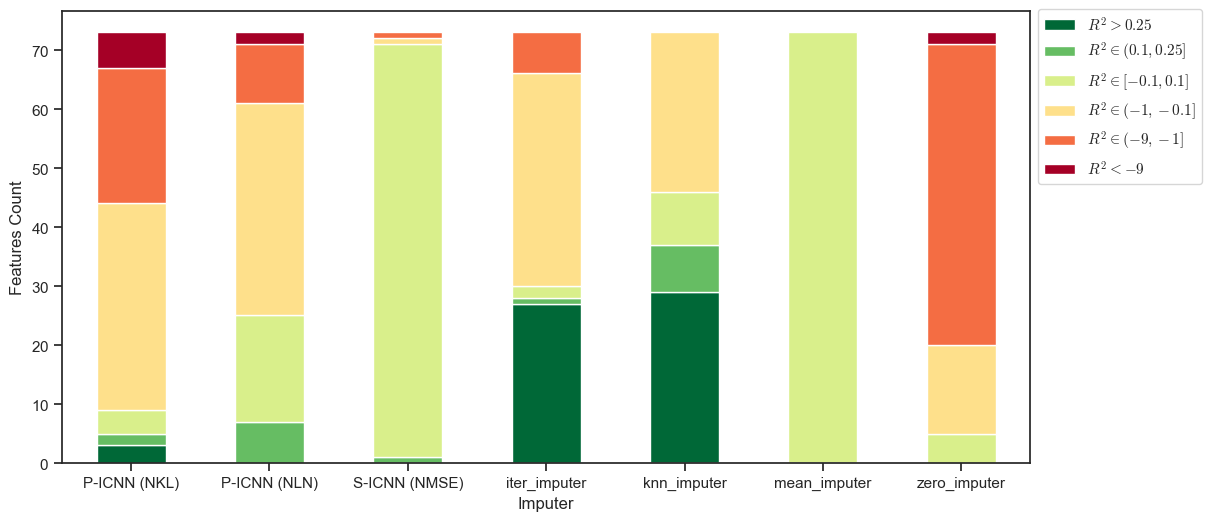

In [72]:
ax = R_bins.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 2, fig_height_in * 3)
ax.get_figure().savefig(f"{RESULTS_DIR}/R2_bins.pdf")

In [73]:
final_models_filtered_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,"$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin
100,P-ICNN (NLN),blood_chemistry.albumin,-0.670892,0.028586,0.079939,0.038830,-0.627276,0.028052,-0.602299,0.027517,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
101,P-ICNN (NLN),blood_chemistry.aniongap,-0.271121,0.025621,0.085741,0.108476,-0.248233,0.025025,-0.220338,0.024517,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
102,P-ICNN (NLN),blood_chemistry.bicarbonate,-0.118142,0.015140,0.060280,0.200523,-0.074612,0.014350,-0.066851,0.014137,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$"
103,P-ICNN (NLN),blood_chemistry.bun,-0.075974,0.045477,0.060521,0.057001,-0.071689,0.044784,-0.071353,0.044119,...,"$r \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$"
104,P-ICNN (NLN),blood_chemistry.calcium,-0.505409,0.006092,0.058225,0.152024,-0.431348,0.005799,-0.401562,0.005671,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
996,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
997,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA
998,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA


In [74]:
mse_cols = ['MSE'] + [f'MSE@P{p}' for p in PERCENTILES]
mse_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_mse_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + mse_cols]
NLN_mse_percentiles = NLN_mse_percentiles.rename(columns=mse_cols_rename)
NLN_mse_percentiles.loc[:, mse_cols_rename.values()] = NLN_mse_percentiles.loc[:, mse_cols_rename.values()].apply(lambda c: c * 100 / NLN_mse_percentiles['P100'], axis=0)
NLN_mse_percentiles['Feature'] = NLN_mse_percentiles.Feature.map(variable_map)
NLN_mse_percentiles = NLN_mse_percentiles.sort_values('Feature')

In [75]:
NLN_mse_percentiles.sort_values('P50').iloc[:15]['Feature']

143                       pH
190            vital.Glucose
175                   CK-CPK
171                      AST
110                bc.Sodium
181             AKI (binary)
156                     MCHC
176                    CK-MB
182                      AKI
150    Creatinine Kinase, MB
169                      ALT
135         FiO2_chartevents
149                CO2 total
185            Urine out 24h
152               Troponin T
Name: Feature, dtype: object

In [86]:
from matplotlib import colormaps
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe


cmap = colormaps['tab20']
grey = colormaps['Greys'](0.5)
uncertainty_aware_set = sorted(NLN_mse_percentiles.sort_values('P50').iloc[:15]['Feature'])
uncertainty_aware_set_colors = {var: cmap(i) for i, var in enumerate(uncertainty_aware_set)}


<Figure size 640x480 with 0 Axes>

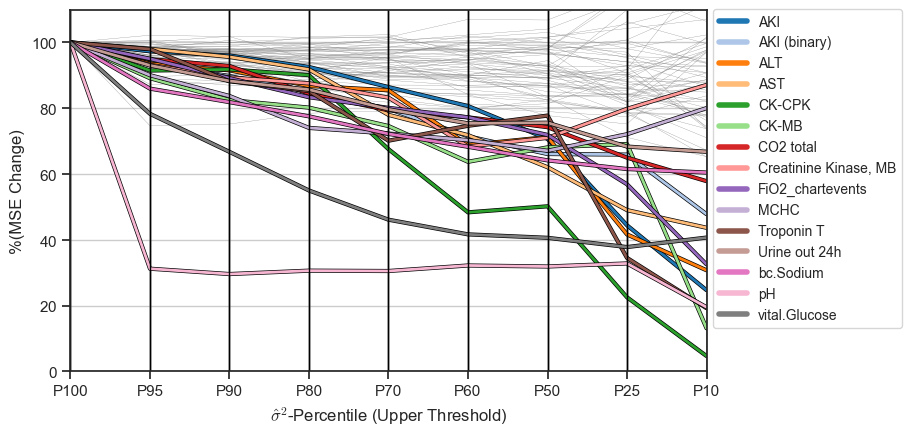

In [87]:
plt.close()
plt.gcf().clear()    
fig, ax = plt.subplots(figsize=(fig_width_in * 1.5, fig_height_in * 2.5))

pd.plotting.parallel_coordinates(NLN_mse_percentiles[~NLN_mse_percentiles.Feature.isin(uncertainty_aware_set)], 
                                      class_column='Feature', color='grey', linewidth=0.2)
pd.plotting.parallel_coordinates(NLN_mse_percentiles[NLN_mse_percentiles.Feature.isin(uncertainty_aware_set)], 
                                      class_column='Feature', color=uncertainty_aware_set_colors.values(),
                                linewidth=2,
                                path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])

# remove the pandas legend
plt.gca().legend_.remove()
plt.grid(True)
plt.ylim(0, 110)
plt.xlabel(r"$\hat{\sigma}^2$-Percentile (Upper Threshold)")
plt.ylabel("%(MSE Change)")
# plt.title("Highlighted Uncertainty-Aware Dimensions")

# add new legend
# topHandle =    mlines.Line2D([],[], color='red',   ls="-", label="Best")
# midHandleOne = mlines.Line2D([],[], color='blue',  ls="-", label="Next Best")
# lowHandle =    mlines.Line2D([],[], color='black', ls="-", label="Worst")
plt.legend(handles=[Line2D([],[], color=c,  
                           ls="-", label=var, lw=4)  for var, c in uncertainty_aware_set_colors.items()],
           loc='upper left', bbox_to_anchor=(1.0, 1.02),
           prop={'size':10})
plt.savefig(f"{RESULTS_DIR}/LNL_uncertainty_thresholds.pdf")
plt.show()


In [80]:
import colorcet as cc
from scipy.stats import gaussian_kde

from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter, Span
from bokeh.plotting import figure, show, curdoc
from bokeh.sampledata.perceptions import probly
from bokeh.io import output_notebook, export_svgs, export_png
output_notebook()


def ridge(category, data, scale=20):
    return list(zip([category]*len(data), scale*data))

percentiles_ = list(mse_cols_rename.values())
palette = [cc.rainbow[i*15] for i in range(len(percentiles_))]

x = np.linspace(-20, 150, 10000)

source = ColumnDataSource(data=dict(x=x))

p = figure(y_range=percentiles_[1:], width=650, height=400, 
           x_range=(-5, 120), 
           # toolbar_location=None, 
           output_backend="svg"
          )

for i, p_i in enumerate(reversed(percentiles_[1:])):
    pdf = gaussian_kde(NLN_mse_percentiles[p_i], bw_method=0.08)
    y = ridge(p_i, pdf(x))
    source.add(y, p_i)
    p.patch('x', p_i, color=palette[i], alpha=0.6, line_color="black", source=source)

p.add_layout(Span(location=100, dimension='height', line_color='red', line_width=5))

# p.y_range.start = '
p.outline_line_color = None
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, 110, 10)))
p.xaxis.formatter = PrintfTickFormatter(format="%d%%")
p.xaxis.axis_label = "%(MSE Change)"
p.yaxis.axis_label = r"\[\hat{\sigma}^2\]-Percentile (Upper Threshold)"

p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"

p.xaxis.major_label_text_font_size = "10pt"
p.yaxis.major_label_text_font_size = "12pt"



p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis.ticker

# p.axis.minor_tick_line_color = None
# p.axis.major_tick_line_color = None
# p.axis.axis_line_color = None

p.y_range.range_padding = 0.1

show(p)


Loading BokehJS ...

In [278]:
# export_svgs(p, filename=f"{RESULTS_DIR}/LNL_mse_changes_thresholds.svg")
# export_png(p, filename=f"{RESULTS_DIR}/LNL_mse_changes_thresholds.png",
#           width=650, height=400)


'/home/asem/GP/ICENODE/notebooks/mimic_icu/exploratory/icnn_results_A/LNL_mse_changes_thresholds.png'

In [ ]:
# Show stacked bar plots for different percentiles.....

In [88]:
NLN_mse_percentiles

,Feature,P100,P95,P90,P80,P70,P60,P50,P25,P10
182,AKI,100.0,97.313588,96.024606,92.548847,86.426456,80.670538,70.690902,44.425248,24.712816
181,AKI (binary),100.0,93.554938,89.776755,84.985571,79.816981,71.484629,66.097223,65.912280,47.815559
168,ALP,100.0,100.481880,95.783939,89.477903,90.853379,92.627233,89.920326,88.703480,101.230619
169,ALT,100.0,93.505610,91.531322,86.793515,85.477616,68.846676,71.236785,41.655837,30.757529
171,AST,100.0,98.031186,95.603113,91.786540,77.990149,71.827233,62.079720,49.041426,43.677067
...,...,...,...,...,...,...,...,...,...,...
144,pO2,100.0,98.576716,98.123547,96.547539,96.202113,93.870314,88.532867,82.021137,87.379914
141,pO2/FiO2 ratio,100.0,94.457486,93.244602,96.161194,92.557508,95.608658,93.301552,88.147188,87.978878
183,renal.Creatinine,100.0,97.635260,97.388485,92.092289,92.221192,86.230790,86.984208,78.271878,67.238655
190,vital.Glucose,100.0,78.307522,66.746713,55.004600,46.131853,41.668950,40.622981,37.812608,40.696360


In [93]:
final_models_filtered_features_stats_df

,Imputer,Feature,$R^2$,MSE,"$r_\text{Spearman}(SE, \hat{\sigma}^2)$","$r_\text{Pearson}(SE, \hat{\sigma}^2)$",$R^2@P95$,MSE@P95,$R^2@P90$,MSE@P90,...,"$r(SE, \hat{\sigma}^2)$ bin",$R^2$ bin,$R^2@P95$ bin,$R^2@P90$ bin,$R^2@P80$ bin,$R^2@P70$ bin,$R^2@P60$ bin,$R^2@P50$ bin,$R^2@P25$ bin,$R^2@P10$ bin
100,P-ICNN (NLN),blood_chemistry.albumin,-0.670892,0.028586,0.079939,0.038830,-0.627276,0.028052,-0.602299,0.027517,...,"$r \in [-0.1, 0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
101,P-ICNN (NLN),blood_chemistry.aniongap,-0.271121,0.025621,0.085741,0.108476,-0.248233,0.025025,-0.220338,0.024517,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
102,P-ICNN (NLN),blood_chemistry.bicarbonate,-0.118142,0.015140,0.060280,0.200523,-0.074612,0.014350,-0.066851,0.014137,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$"
103,P-ICNN (NLN),blood_chemistry.bun,-0.075974,0.045477,0.060521,0.057001,-0.071689,0.044784,-0.071353,0.044119,...,"$r \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$","$R^2 \in [-0.1, 0.1]$"
104,P-ICNN (NLN),blood_chemistry.calcium,-0.505409,0.006092,0.058225,0.152024,-0.431348,0.005799,-0.401562,0.005671,...,"$r \in [0.1, 0.3]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$","$R^2 \in (-1, -0.1]$"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,iter_imputer,vital.sbp,0.452593,0.007647,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
996,iter_imputer,vital.sbp_ni,0.820376,0.002518,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,$R^2 > 0.25$,NA,NA,NA,NA,NA,NA,NA,NA
997,iter_imputer,vital.spo2,-0.972564,0.001281,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA
998,iter_imputer,vital.temperature,-0.918125,0.000421,NaN,NaN,NaN,NaN,NaN,NaN,...,NA,"$R^2 \in (-1, -0.1]$",NA,NA,NA,NA,NA,NA,NA,NA


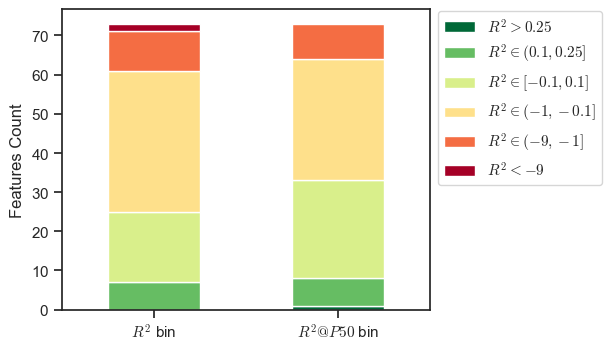

In [122]:
# final_models_filtered_features_stats_df.columns
r2_bin_cols = [r'$R^2$ bin'] + [fr'$R^2@P{p}$ bin' for p in PERCENTILES]
# r2_bin_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_R2_bins_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + r2_bin_cols]
NLN_R2_bins_percentiles = NLN_R2_bins_percentiles.set_index('Feature')
NLN_R2_bins_dist_percentiles = {col: NLN_R2_bins_percentiles.groupby(col)[col].count() for col in r2_bin_cols}
NLN_R2_bins_dist_percentiles = pd.DataFrame(NLN_R2_bins_dist_percentiles)[[r2_bin_cols[0], r2_bin_cols[6]]].transpose()
NLN_R2_bins_dist_percentiles = NLN_R2_bins_dist_percentiles[R_classes]
ax = NLN_R2_bins_dist_percentiles.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in, fig_height_in * 2)
# ax.get_figure().savefig(f"{RESULTS_DIR}/R2_bins.pdf")



In [ ]:
mse_cols = ['MSE'] + [f'MSE@P{p}' for p in PERCENTILES]
mse_cols_rename = {'MSE': 'P100'} | {f'MSE@P{p}': f'P{p}' for p in PERCENTILES}
NLN_mse_percentiles = final_models_filtered_features_stats_df.loc[final_models_filtered_features_stats_df.Imputer == 'P-ICNN (NLN)', ['Feature'] + mse_cols]
# NLN_mse_percentiles = NLN_mse_percentiles.rename(columns=mse_cols_rename)
# NLN_mse_percentiles.loc[:, mse_cols_rename.values()] = NLN_mse_percentiles.loc[:, mse_cols_rename.values()].apply(lambda c: c * 100 / NLN_mse_percentiles['P100'], axis=0)
# NLN_mse_percentiles['Feature'] = NLN_mse_percentiles.Feature.map(variable_map)
# NLN_mse_percentiles = NLN_mse_percentiles.sort_values('Feature')

In [ ]:

R_bins = final_models_filtered_features_stats_df.groupby(['Imputer', r'$R^2$ bin'])['Feature'].count().reset_index()
R_bins.columns = ['Imputer', r'$R^2$ bin', 'Count']
R_bins = R_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$ bin')

R_bins = R_bins[R_classes]
R_bins